**Identificação de cilindros em arquivos pointcloud**

In [5]:
import open3d as o3d
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [53]:
# Load the original pointcloud
#pcd    = o3d.io.read_point_cloud("pcd_files/ring_wall_2.pcd")
pcd    = o3d.io.read_point_cloud("pcd_files/ring_outer_wall.pcd")
points = np.asarray(pcd.points)

# Normal estimation
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=30))

# Visualization
o3d.visualization.draw_geometries([pcd])

**Filtragem de outliers da nuvem de pontos.**

In [55]:
# Parameters
z_min = 0.11                           # Minimum Z to keep (adjust to your data)
square_size = 0.2                      # 200 mm in meters
center_x, center_y = -0.0025, 0.0015   # Set your known center coordinates
inner_radius = 0.018                   # Screw radius

# Z Filter
mask_z = points[:, 2] >= z_min

# XY Filter
half_size = square_size / 2
mask_xy = (
    (points[:, 0] >= center_x - half_size) &
    (points[:, 0] <= center_x + half_size) &
    (points[:, 1] >= center_y - half_size) &
    (points[:, 1] <= center_y + half_size)
)

# Screw area removal
distances = np.sqrt((points[:, 0] - center_x)**2 + (points[:, 1] - center_y)**2)
mask_inner_circle = distances >= inner_radius  # Keep only points outside this radius

# Combine filters
mask = mask_z & mask_xy & mask_inner_circle
filtered_points = points[mask]

# Update Point Cloud
filtered_pcd = o3d.geometry.PointCloud()
filtered_pcd.points = o3d.utility.Vector3dVector(filtered_points)

# If you have colors or normals, keep them too:
if pcd.has_colors():
    colors = np.asarray(pcd.colors)[mask]
    filtered_pcd.colors = o3d.utility.Vector3dVector(colors)
if pcd.has_normals():
    normals = np.asarray(pcd.normals)[mask]
    filtered_pcd.normals = o3d.utility.Vector3dVector(normals)

# Visualization
o3d.io.write_point_cloud("substract_filtered.pcd", filtered_pcd)
o3d.visualization.draw_geometries([filtered_pcd])

**Removendo a nuvem de pontos relacionada ao substrato**

In [57]:
# Set RANSAC parameters
distance_threshold = 0.0025  # Max distance a point can be from the plane to be considered an inlier.
ransac_n = 3                 # Number of points sampled to estimate a plane.
num_iterations = 5000        # How many random samples to try.

# Perform plane segmentation to find the plane model and the indices of inlier points
plane_model, inlier_indices = filtered_pcd.segment_plane(distance_threshold=distance_threshold,
                                                ransac_n=ransac_n,
                                                num_iterations=num_iterations)

# The plane model is [a, b, c, d] for the plane equation ax + by + cz + d = 0
[a, b, c, d] = plane_model
# print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.4f} = 0")

# The 'invert=True' argument selects all points that are NOT in the inlier_indices list
# cylinder_cloud = pcd.select_by_index(inlier_indices, invert=True)
cylinder_cloud = filtered_pcd.select_by_index(inlier_indices, invert=True)

# For verification, you can also get the substrate cloud and color it
substrate_cloud = filtered_pcd.select_by_index(inlier_indices)
substrate_cloud.paint_uniform_color([0, 0, 1.0]) # Color the substrate red

# print("Showing the substract.")
o3d.visualization.draw_geometries(
    [substrate_cloud], 
    window_name="Verification - Press 'q' to close"
)

# 5. Show and save the final result
# print("Displaying the final, isolated cylinder.")
# o3d.visualization.draw_geometries(
#     [cylinder_cloud], 
#     window_name="Final Result: Isolated Cylinder"
# )

print(f"Substrate height with respect to KP2 Tool0: {np.abs(d):.4f} m")

# Saving substract isolated pointcloud
substract_filename = "substract.pcd"
success = o3d.io.write_point_cloud(substract_filename, substrate_cloud)

Substrate height with respect to KP2 Tool0: 0.1139 m


**Remoção do topo da peça**

In [65]:
# Set RANSAC parameters
distance_threshold = 0.0025     # Max distance a point can be from the plane to be considered an inlier.
ransac_n = 3                   # Number of points sampled to estimate a plane.
num_iterations = 5000         # How many random samples to try.

# Perform plane segmentation to find the plane model and the indices of inlier points
top_plane_model, top_inlier_indices = cylinder_cloud.segment_plane(distance_threshold=distance_threshold,
                                                ransac_n=ransac_n,
                                                num_iterations=num_iterations)

[a, b, c, d] = top_plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.4f} = 0")

only_cylinder = cylinder_cloud.select_by_index(top_inlier_indices, invert=True)

# For verification, you can also get the top cloud and color it
top_cloud = cylinder_cloud.select_by_index(top_inlier_indices)
top_cloud.paint_uniform_color([1.0, 0, 0]) # Color the tope red

# o3d.visualization.draw_geometries(
#     [top_cloud], 
#     window_name="Verification - Press 'q' to close"
# )

o3d.visualization.draw_geometries(
    [only_cylinder], 
    window_name="Verification - Press 'q' to close"
)

# Saving the pointcloud of the internal/external walls
only_cylinder_filename = "processed_cylinder_walls.pcd"
success = o3d.io.write_point_cloud(only_cylinder_filename, only_cylinder)

Plane equation: -0.00x + -0.00y + 1.00z + -0.1421 = 0


**Fitting circunference to internal and external walls**

In [3]:
def fit_circle(points_xy):
    x = points_xy[:, 0]
    y = points_xy[:, 1]
    A = np.c_[2*x, 2*y, np.ones_like(x)]
    b = x**2 + y**2
    xc, yc, c = np.linalg.lstsq(A, b, rcond=None)[0]
    r = np.sqrt(c + xc**2 + yc**2)
    return xc, yc, r

def create_circle(xc, yc, r, z, num_points=200, color=[1,0,0]):
    theta = np.linspace(0, 2*np.pi, num_points)
    circle_pts = np.c_[xc + r*np.cos(theta),
                       yc + r*np.sin(theta),
                       np.full(num_points, z)]
    pcd_circle = o3d.geometry.PointCloud()
    pcd_circle.points = o3d.utility.Vector3dVector(circle_pts)
    pcd_circle.paint_uniform_color(color)
    return pcd_circle

# Showing both circunferences, related to internal and external walls
points = np.asarray(only_cylinder.points)
xy_points = points[:, :2]  # keep X and Y only

xc_all, yc_all, _ = fit_circle(xy_points)
z = 0.1147     # substract height w.r.t. deposition_frame (kp2_tool0)

# Compute distances from fitted global center 
radius = np.linalg.norm(xy_points - np.array([xc_all, yc_all]), axis=1)

# Cluster radius into inner/outer 
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
labels = kmeans.fit_predict(radius.reshape(-1, 1))    # returns the array of cluster labels each data point belongs to

# Identify which label is inner and which is outer
mean_radius = [np.mean(radius[labels == i]) for i in range(2)]
inner_label = np.argmin(mean_radius)
outer_label = np.argmax(mean_radius)

inner_points = xy_points[labels == inner_label]
outer_points = xy_points[labels == outer_label]

# Fit each circle separately
xc_in, yc_in, r_in    = fit_circle(inner_points)
xc_out, yc_out, r_out = fit_circle(outer_points)

print(f"Inner circle center: ({xc_in:.4f}, {yc_in:.4f}), radius: {r_in:.4f}")
print(f"Outer circle center: ({xc_out:.4f}, {yc_out:.4f}), radius: {r_out:.4f}")
print(f"Wall thickness = {r_out - r_in:.4f}")

circle_inner = create_circle(xc_in, yc_in, r_in, z, color=[0, 0, 0])     # red
circle_outer = create_circle(xc_out, yc_out, r_out, z, color=[0, 0, 0])  # green

pcd.paint_uniform_color([0, 0, 1])  # original cloud in blue
o3d.visualization.draw_geometries([only_cylinder, circle_inner, circle_outer])

NameError: name 'np' is not defined

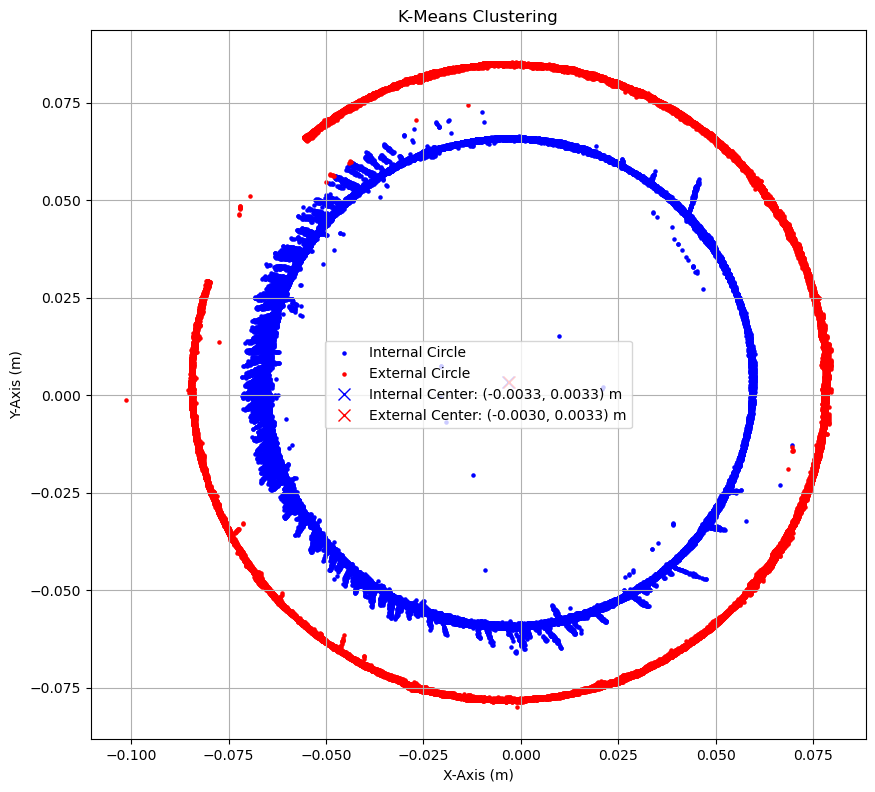

In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

fig, ax = plt.subplots(figsize=(10, 10))

# Plotting clusters points
ax.scatter(inner_points[:, 0], inner_points[:, 1], c='blue', label='Internal Circle', s=5)
ax.scatter(outer_points[:, 0], outer_points[:, 1], c='red', label='External Circle', s=5)

# Marker: inner circle
ax.plot(
    xc_in,
    yc_in,
    marker='x',      
    markersize=8,    
    color='blue',    
    linestyle='none',
    label=f'Internal Center: ({xc_in:.4f}, {yc_in:.4f}) m'
)

# Marker: outer circle
ax.plot(
    xc_out,
    yc_out,
    marker='x',      
    markersize=8,    
    color='red',
    linestyle='none',
    label=f'External Center: ({xc_out:.4f}, {yc_out:.4f}) m'
)

# Visualization
ax.set_title('K-Means Clustering')
ax.set_xlabel('X-Axis (m)')
ax.set_ylabel('Y-Axis (m)')
ax.legend()
ax.grid(True)
ax.set_aspect('equal', adjustable='box')

# 5. Salva e exibe o gráfico
plt.savefig('kmeans_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

In [80]:
# Defining a subset of points that lie exaclty or very close to the inner circunference
def points_on_circumference(pcd, center, radius, tolerance=0.001):
    """
    Returns indices and points from the PCD that lie on the circumference
    within the given tolerance.
    """
    # Convert to numpy
    points = np.asarray(pcd.points)
    
    # Distance from each point to the center (in XY plane)
    distances = np.sqrt((points[:, 0] - center[0])**2 + 
                        (points[:, 1] - center[1])**2)
    
    # Select points whose radial distance is within tolerance of the radius
    mask = np.abs(distances - radius) <= tolerance
    selected_points = points[mask]
    
    return selected_points, np.where(mask)[0]

# Example usage:
pcd = o3d.io.read_point_cloud("substract.pcd")

center_inner = np.array([0.0, 0.0])    # Your fitted center (x, y)
radius_inner = 0.06135                 # Your fitted radius (meters)
tolerance = 0.001                      # 1 mm tolerance

inner_points, inner_indices = points_on_circumference(pcd, center_inner, radius_inner, tolerance)

print(f"Found {len(inner_points)} points on the internal wall.")

# Visualization
pcd_inner = o3d.geometry.PointCloud()
pcd_inner.points = o3d.utility.Vector3dVector(inner_points)
pcd_inner.paint_uniform_color([1, 0, 0])  # Red for visibility

o3d.visualization.draw_geometries([pcd, pcd_inner])


Found 938 points on the internal wall.
